<a href="https://colab.research.google.com/github/Khadiza13/POS_Attachment/blob/main/Bangla_POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
file_path = '/content/drive/MyDrive/final_pos.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Parse the sentences and their corresponding POS tags
sentences = []
pos_tags = []
for i in range(0, len(lines), 2):  # Every odd line is POS tags, every even line is sentence
    sentence = lines[i].strip()
    pos_tag = lines[i+1].strip()

    # Tokenizing the sentence and POS tag
    word_list = sentence.split()  # List of words in sentence
    pos_list = pos_tag.split()  # List of POS tags corresponding to words

    # Ensure both lists have the same length
    assert len(word_list) == len(pos_list)

    sentences.append(' '.join(word_list))
    pos_tags.append(' '.join(pos_list))

# Convert the data into a DataFrame
df = pd.DataFrame({'Sentence': sentences, 'POS': pos_tags})



In [20]:
df

,Sentence,POS
0,তাঁকে বাংলা ভাষার সর্বশ্রেষ্ঠ সাহিত্যিক মনে কর...,PRP NNP NN JJ NN VB VB VB
1,রবীন্দ্রনাথকে গুরুদেব কবিগুরু ও বিশ্বকবি অভিধা...,NNP NNP NNP CC NN NN VB VB VB
2,এছাড়া তিনি প্রায় দুই হাজার ছবি এঁকেছিলেন,RB PRP IN CD CD NNS VB
3,রবীন্দ্রনাথের রচনা বিশ্বের বিভিন্ন ভাষায় অনূদ...,NNP NNS NN JJ NNS VB VB
4,আট বছর বয়সে তিনি কবিতা লেখা শুরু করেন,CD NN NN PRP NN VB VB VB
...,...,...
846,এই নৃত্যে ঐতিহ্যবাহী পোশাক পরিধান করা হয়,DT NN JJ NNS VB VB VB
847,আদিয়ামানস্পোর এই শহরের একটি ফুটবল দল,NNP DT NN DT NN NN
848,স্যাটারিকন ব্যান্ডের মোট দুইজন সদস্য আছে,JJ NN NN CD NN VB
849,এ পর্যন্ত ৭টি স্টুডিও অ্যালবাম বের হয়েছে এ ব্...,RB RB CD NN NNS VB VB JJ NN


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


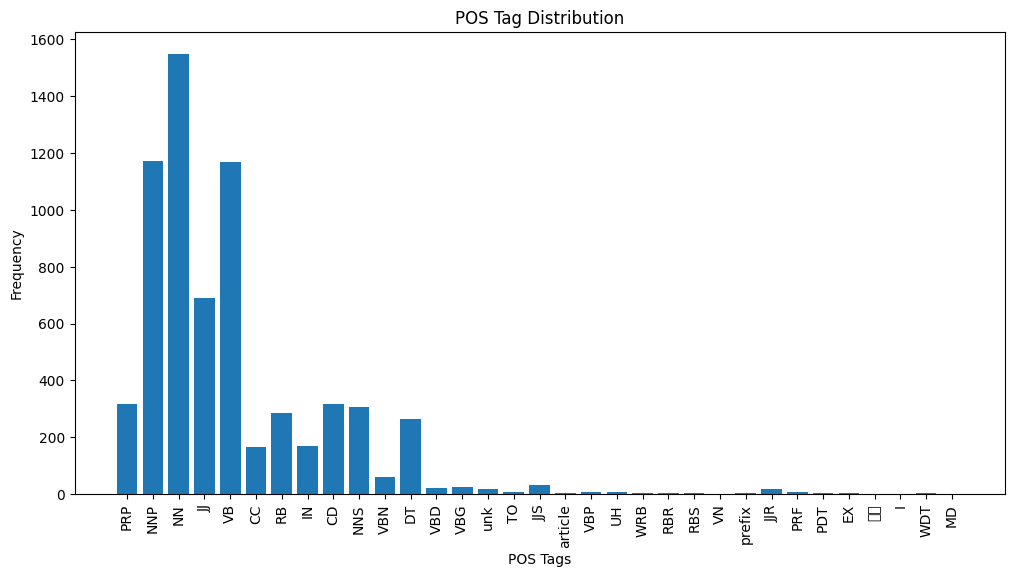

In [21]:
all_pos_tags = ' '.join(pos_tags).split()  # Flatten all POS tags into a single list
pos_counts = Counter(all_pos_tags)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.xticks(rotation=90)
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.title('POS Tag Distribution')
plt.show()

In [22]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split 30% temp into 15% each

# Print dataset sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 595
Validation set size: 128
Test set size: 128


In [23]:
class POSDataset(Dataset):
    def __init__(self, sentences, pos_tags, tokenizer, label_map, max_len=128):
        self.sentences = sentences
        self.pos_tags = pos_tags
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, index):
        sentence = self.sentences[index]
        pos_tags = self.pos_tags[index].split()

        # Tokenize with word alignment
        encoding = self.tokenizer(
            sentence.split(),
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_offsets_mapping=True,
        )

        word_ids = encoding.word_ids()
        labels = [-100 if word_id is None else self.label_map.get(pos_tags[word_id], 0) for word_id in word_ids]

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }


# Create a label map
label_map = {tag: i for i, tag in enumerate(pos_counts.keys())}

from transformers import AutoModelForTokenClassification

num_labels = len(label_map)
model = AutoModelForTokenClassification.from_pretrained("csebuetnlp/banglabert", num_labels=num_labels)


# Load tokenizer and model
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Prepare datasets
train_dataset = POSDataset(train_df["Sentence"].tolist(), train_df["POS"].tolist(), tokenizer, label_map)
valid_dataset = POSDataset(valid_df["Sentence"].tolist(), valid_df["POS"].tolist(), tokenizer, label_map)
test_dataset = POSDataset(test_df["Sentence"].tolist(), test_df["POS"].tolist(), tokenizer, label_map)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Flatten predictions and labels for comparison
    true_labels = labels.flatten()
    pred_labels = predictions.flatten()

    # Filter out padding tokens (label 0)
    valid_indices = true_labels > 0
    true_labels = true_labels[valid_indices]
    pred_labels = pred_labels[valid_indices]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="macro")
    accuracy = accuracy_score(true_labels, pred_labels)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,  # Log every 10 steps
    log_level="info",  # Set logging level to info
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    learning_rate=5e-5,  # Reduced learning rate
    warmup_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]  # Disable reporting to W&B
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-722e6df0002f>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
***** Running training *****
  Num examples = 595
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 380
  Number of trainable parameters = 110,052,129


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.399000,3.301170,0.253279,0.027510,0.036971,0.030600
2,3.010600,2.692669,0.362295,0.038380,0.065151,0.046458
3,2.170200,1.904734,0.541803,0.081641,0.113894,0.094049
4,1.544200,1.331536,0.664754,0.231853,0.188550,0.184458
5,1.109300,1.078071,0.724590,0.260005,0.261985,0.254903
6,1.016800,0.929858,0.757377,0.321326,0.307316,0.302998
7,0.835600,0.900820,0.763115,0.324306,0.324034,0.320814
8,0.675600,0.924614,0.740164,0.320501,0.326770,0.320107
9,0.554600,0.890878,0.773770,0.322252,0.353823,0.335565
10,0.422800,0.876112,0.772131,0.332167,0.347916,0.338766



***** Running Evaluation *****
  Num examples = 128
  Batch size = 16
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to ./results/checkpoint-38
Configuration saved in ./results/checkpoint-38/config.json
Model weights saved in ./results/checkpoint-38/model.safetensors
tokenizer config file saved in ./results/checkpoint-38/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-3

TrainOutput(global_step=380, training_loss=1.5471949113042731, metrics={'train_runtime': 251.5196, 'train_samples_per_second': 23.656, 'train_steps_per_second': 1.511, 'total_flos': 388787860339200.0, 'train_loss': 1.5471949113042731, 'epoch': 10.0})

In [26]:
results = trainer.evaluate(test_dataset)

# Display metrics
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test Precision: {results['eval_precision']:.4f}")
print(f"Test Recall: {results['eval_recall']:.4f}")
print(f"Test F1 Score: {results['eval_f1']:.4f}")


***** Running Evaluation *****
  Num examples = 128
  Batch size = 16


Test Accuracy: 0.7682
Test Precision: 0.2965
Test Recall: 0.3134
Test F1 Score: 0.3044


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from sklearn.metrics import classification_report
import numpy as np

# Function to evaluate model and generate classification report
def generate_classification_report(trainer, test_dataset, label_map):
    # Predict on the test dataset
    predictions, labels, _ = trainer.predict(test_dataset)
    pred_labels = np.argmax(predictions, axis=-1)

    # Flatten predictions and true labels, removing padding (-100)
    true_labels = labels.flatten()
    pred_labels = pred_labels.flatten()
    valid_indices = true_labels > -100  # Ignore padding tokens
    true_labels = true_labels[valid_indices]
    pred_labels = pred_labels[valid_indices]

    # Convert label IDs back to label names for clarity
    id_to_label = {v: k for k, v in label_map.items()}
    true_labels_named = [id_to_label[label] for label in true_labels]
    pred_labels_named = [id_to_label[label] for label in pred_labels]

    # Generate classification report
    report = classification_report(true_labels_named, pred_labels_named, digits=4)
    print("Classification Report:\n")
    print(report)

    return report

# Generate the report
classification_report = generate_classification_report(trainer, test_dataset, label_map)


***** Running Prediction *****
  Num examples = 128
  Batch size = 16


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:

              precision    recall  f1-score   support

          CC     0.8750    0.9130    0.8936        23
          CD     0.8841    0.9839    0.9313        62
          DT     0.9268    0.9500    0.9383        40
          EX     0.0000    0.0000    0.0000         1
           I     0.0000    0.0000    0.0000         1
          IN     0.5161    0.5000    0.5079        32
          JJ     0.6667    0.6667    0.6667       108
         JJR     0.0000    0.0000    0.0000         6
         JJS     0.0000    0.0000    0.0000         3
          NN     0.7263    0.7500    0.7380       276
         NNP     0.8478    0.8566    0.8522       286
         NNS     0.6000    0.7619    0.6713        63
         PRF     0.0000    0.0000    0.0000         1
         PRP     0.9423    0.9608    0.9515        51
          RB     0.4754    0.5577    0.5133        52
          TO     0.0000    0.0000    0.0000         5
          UH     0.0000    0.0000    0.0000         1
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
